In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Train Data

In [2]:
from data_processing import get_tabular_dataset2

data_train, data_test = get_tabular_dataset2()

Loading data... Done.
Creating features... precip t td hu ff dd Done.
Loading data... Done.
Creating features... precip t td hu ff dd Done.


In [2]:
data_train = pd.read_csv("Data/Train/tabular_train.csv")
data_test = pd.read_csv("Data/Test/tabular_test.csv")

In [3]:
data_train["Id_split"] = data_train["Id"].str.split("_")
data_train["number_sta"] = data_train["Id_split"].apply(lambda s: s[0]).astype(int)
data_train["day"] = data_train["Id_split"].apply(lambda s: s[1]).astype(int)

In [6]:
temp = data_train.sort_values(["number_sta", "day"])#[["number_sta", "day", "precip_cumul", "Ground_truth"]]
temp["precip_shift"] = temp["precip_cumul"].shift(-1)
temp

,Id,Ground_truth,baseline_obs,baseline_pred,lat,lon,height_sta,precip_cumul,precip_0,precip_1,...,dd_18,dd_19,dd_20,dd_21,dd_22,dd_23,Id_split,number_sta,day,precip_shift
0,14066001_0,3.4,0.2,5.545129,49.334,-0.431,2.0,0.2,0.0,0.0,...,130.0,138.0,149.0,149.0,150.0,142.0,"[14066001, 0]",14066001,0,3.4
226,14066001_1,11.7,3.4,7.372426,49.334,-0.431,2.0,3.4,0.0,0.0,...,240.0,234.0,241.0,237.0,232.0,222.0,"[14066001, 1]",14066001,1,11.7
449,14066001_2,0.6,11.7,2.889161,49.334,-0.431,2.0,11.7,0.0,0.0,...,198.0,212.0,225.0,252.0,219.0,230.0,"[14066001, 2]",14066001,2,0.6
671,14066001_3,0.4,0.6,6.140569,49.334,-0.431,2.0,0.6,0.0,0.0,...,210.0,207.0,201.0,203.0,208.0,200.0,"[14066001, 3]",14066001,3,0.4
892,14066001_4,3.0,0.4,3.744201,49.334,-0.431,2.0,0.4,0.0,0.0,...,194.0,202.0,210.0,207.0,209.0,200.0,"[14066001, 4]",14066001,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161198,95690001_725,3.2,2.4,10.618165,49.108,1.831,126.0,2.4,0.0,0.0,...,170.0,171.0,171.0,176.0,183.0,177.0,"[95690001, 725]",95690001,725,3.2
161424,95690001_726,0.0,3.2,0.000239,49.108,1.831,126.0,3.2,0.0,0.0,...,302.0,300.0,300.0,299.0,285.0,282.0,"[95690001, 726]",95690001,726,0.0
161649,95690001_727,4.4,0.0,5.269440,49.108,1.831,126.0,0.0,0.0,0.0,...,232.0,262.0,221.0,248.0,236.0,233.0,"[95690001, 727]",95690001,727,4.4
161878,95690001_728,5.4,4.4,12.161292,49.108,1.831,126.0,4.4,0.0,0.0,...,259.0,266.0,251.0,232.0,232.0,224.0,"[95690001, 728]",95690001,728,5.4


In [14]:
from data_processing import add_nbr_precp

data_train = add_nbr_precp(data_train, K=5)

100%|██████████| 730/730 [00:14<00:00, 48.70it/s]


In [151]:
data_test = add_nbr_precp(data_test, K=5)

100%|██████████| 363/363 [00:07<00:00, 49.22it/s]


In [152]:
data_test["mean_nbr_precip"] = data_test[["precip_cumul"] + [f"nbr{k}_precip" for k in range(1, 5+1)]].mean(axis=1)
data_test["number_sta"] = data_test["Id"].str.split("_").apply(lambda s: s[0]).astype(int)
for d in range(1,8):
    data_test[f"precip_day-{d}"] = data_test.groupby("number_sta")["precip_cumul"].shift(d)
for d in range(2, 8):
    data_test[f"precip_avg{d}d"] = data_test[["precip_cumul"] + [f"precip_day-{k}" for k in range(1, d)]].mean(axis=1)

In [15]:
data_train["mean_nbr_precip"] = data_train[["precip_cumul"] + [f"nbr{k}_precip" for k in range(1, 5+1)]].mean(axis=1)

In [119]:
data_train["number_sta"] = data_train["Id"].str.split("_").apply(lambda s: s[0]).astype(int)
for d in range(1,8):
    data_train[f"precip_day-{d}"] = data_train.groupby("number_sta")["precip_cumul"].shift(d)
data_train

,Id,Ground_truth,baseline_obs,baseline_pred,lat,lon,height_sta,precip_cumul,precip_0,precip_1,...,nbr5_precip,mean_nbr_precip,number_sta,precip_day-1,precip_day-2,precip_day-3,precip_day-4,precip_day-5,precip_day-6,precip_day-7
0,14066001_0,3.4,0.2,5.545129,49.334,-0.431,2.0,0.2,0.0,0.0,...,NaN,4.925000,14066001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14126001_0,0.5,0.5,6.791890,49.145,0.042,125.0,0.5,0.0,0.0,...,1.6,0.980000,14126001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14137001_0,3.4,NaN,6.423514,49.180,-0.456,67.0,0.0,0.0,0.0,...,0.4,3.180000,14137001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14216001_0,4.0,0.6,8.490187,48.928,-0.149,155.0,0.6,0.0,0.0,...,1.8,0.933333,14216001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14296001_0,13.3,0.2,26.130000,48.795,-1.037,336.0,0.2,0.0,0.0,...,NaN,1.533333,14296001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162102,86137003_729,5.0,NaN,6.368405,47.035,0.098,96.0,3.4,1.0,0.8,...,NaN,5.400000,86137003,1.2,0.0,2.4,5.8,0.0,0.0,0.4
162103,86165005_729,3.2,NaN,2.460211,46.412,0.841,153.0,5.6,1.2,0.8,...,5.6,5.866667,86165005,1.2,1.6,5.0,4.8,0.0,0.0,0.6
162104,86272002_729,1.8,NaN,3.793858,46.839,0.457,120.0,5.6,1.2,1.2,...,NaN,5.600000,86272002,1.6,0.2,1.2,5.0,0.0,0.0,0.0
162105,91200002_729,1.6,NaN,4.961200,48.526,1.993,116.0,5.6,0.4,2.2,...,20.6,9.680000,91200002,7.3,0.0,1.2,0.4,0.2,0.0,3.4


In [153]:
X_station_test = pd.read_csv("Data/Test/X_station_test.csv")
X_station_test["Id_split"] = X_station_test["Id"].str.split("_")
# X_station["hour"] = X_station["Id_split"].apply(lambda s: s[-1]).astype(int)
X_station_test["Id"] = X_station_test["Id_split"].apply(lambda s: s[:2]).str.join("_")

In [154]:
data_test = data_test.merge(X_station_test[["Id", "month"]].groupby("Id").first().reset_index(), on="Id", how="left")

In [120]:
for d in range(2, 8):
    data_train[f"precip_avg{d}d"] = data_train[["precip_cumul"] + [f"precip_day-{k}" for k in range(1, d)]].mean(axis=1)

In [39]:
from sklearn.model_selection import train_test_split

X = data_train.drop(columns=["Id","Ground_truth"])
y = np.log(1 + data_train["Ground_truth"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [19]:
X_station = pd.read_csv(f"Data/Test/X_station_test.csv")

In [20]:
X_station_test = pd.read_csv("Data/Test/X_station_test.csv")
X_station_test["Id_split"] = X_station_test["Id"].str.split("_")
# X_station["hour"] = X_station["Id_split"].apply(lambda s: s[-1]).astype(int)
# X_station_test["Id"] = X_station_test["Id_split"].apply(lambda s: s[:2]).str.join("_")
X_station_test[["number_sta", "day", "hour"]] = X_station_test["Id_split"].tolist()

In [27]:
X_station_test["day"].astype(int).sort_values()

1329222      0
1325035      0
1325036      0
1325037      0
1325038      0
          ... 
241336     362
241335     362
241334     362
241356     362
238822     362
Name: day, Length: 2304802, dtype: int32

In [23]:
X_station_test.groupby(["day", "number_sta"]).first().sort_values(["day", "number_sta"])

dd    hu      td       t    ff  precip  month  \
day number_sta                                                     
0   14066001    224.0  96.1  277.17  277.75  3.46     0.0      2   
    14126001      NaN  99.0  278.95  279.05   NaN     0.0      2   
    14137001    242.0  94.7  278.37  279.13  3.47     0.0      2   
    14216001    235.0  92.7  277.50  278.56  2.16     0.0      2   
    14296001      NaN   NaN     NaN  278.55   NaN     0.0      2   
...               ...   ...     ...     ...   ...     ...    ...   
99  86137003    134.0  97.6  270.41  270.75  2.92     0.0     12   
    86165005     85.0  94.2  268.88  269.69  1.16     0.0     12   
    86272002      NaN   NaN     NaN  269.20   NaN     0.0     12   
    91200002    173.0  87.8  267.80  269.52  0.49     0.0     12   
    95690001    125.0  92.6  267.86  268.87  1.33     0.0     12   

                           Id           Id_split hour  
day number_sta                                         
0   14066001     14066001_0_0   [14066001, 0, 0]    0  
    14126001     14126001_0_0   [14126001, 0, 0]    0  
    14137001     14137001_0_0   [14137001, 0, 0]    0  
    14216001     14216001_0_0   [14216001, 0, 0]    0  
    14296001     14296001_0_0   [14296001, 0, 0]    0  
...                       ...                ...  ...  
99  86137003    86137003_99_0  [86137003, 99, 0]    0  
    86165005    86165005_99_0  [86165005, 99, 0]    0  
    86272002    86272002_99_0  [86272002, 99, 0]    0  
    91200002    91200002_99_0  [91200002, 99, 0]    0  
    95690001    95690001_99_0  [95690001, 99, 0]    0  

[96055 rows x 10 columns]

In [122]:
data_train = data_train.merge(X_station[["Id", "month"]].groupby("Id").first().reset_index(), on="Id", how="left")

# Model training

In [7]:
def MAPE(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true+1)))

In [84]:
from xgboost import XGBRegressor

xgb_gpu = XGBRegressor(
    objective = "reg:squarederror",
    tree_method = 'gpu_hist', 
    n_estimators = 3000,
    max_depth = 9,
    # max_bin = 512,
    learning_rate = 0.1,
    # colsample_bytree = 0.9,
    gpu_id = 0,
    verbosity=1
)

In [85]:
xgb_gpu.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)

[0]	validation_0-rmse:0.78177
[1]	validation_0-rmse:0.73338
[2]	validation_0-rmse:0.69168
[3]	validation_0-rmse:0.65559
[4]	validation_0-rmse:0.62477
[5]	validation_0-rmse:0.59841
[6]	validation_0-rmse:0.57629
[7]	validation_0-rmse:0.55703
[8]	validation_0-rmse:0.54100
[9]	validation_0-rmse:0.52750
[10]	validation_0-rmse:0.51591
[11]	validation_0-rmse:0.50625
[12]	validation_0-rmse:0.49819
[13]	validation_0-rmse:0.49176
[14]	validation_0-rmse:0.48591
[15]	validation_0-rmse:0.48133
[16]	validation_0-rmse:0.47726
[17]	validation_0-rmse:0.47391
[18]	validation_0-rmse:0.47094
[19]	validation_0-rmse:0.46837
[20]	validation_0-rmse:0.46611
[21]	validation_0-rmse:0.46435
[22]	validation_0-rmse:0.46267
[23]	validation_0-rmse:0.46120
[24]	validation_0-rmse:0.45978
[25]	validation_0-rmse:0.45835
[26]	validation_0-rmse:0.45744
[27]	validation_0-rmse:0.45660
[28]	validation_0-rmse:0.45573
[29]	validation_0-rmse:0.45496
[30]	validation_0-rmse:0.45404
[31]	validation_0-rmse:0.45349
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

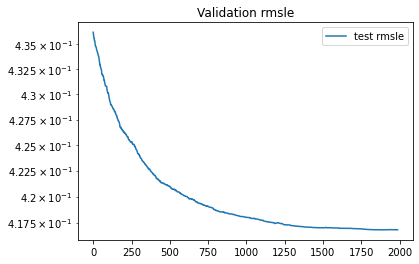

In [86]:
evals_result = xgb_gpu.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmse'][100:], label='test rmsle')
plt.title('Validation rmsle')
plt.legend()
plt.show()

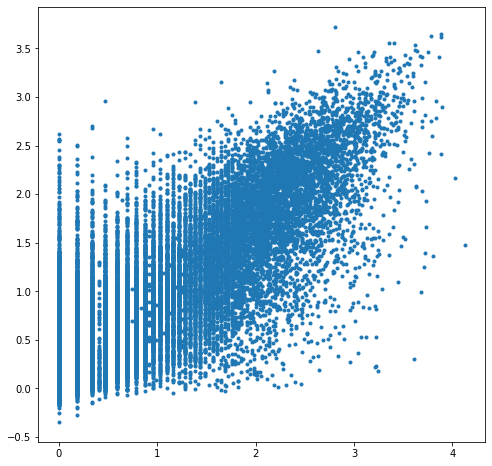

28.777117011407444


In [87]:
y_pred = xgb_gpu.predict(X_test)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_test, y_pred, ".")
# plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_test)-1, np.exp(y_pred)-1)) # previous best: 27.9057

In [89]:
from xgboost import XGBRegressor

xgb_gpu = XGBRegressor(
    objective = "reg:squarederror",
    eva_metric = "rmse",
    tree_method = 'gpu_hist', 
    n_estimators = 3000,
    max_depth = 12,
    # max_bin = 512,
    learning_rate = 0.1,
    # colsample_bytree = 0.9,
    gpu_id = 0,
    verbosity=1
)

In [90]:
xgb_gpu.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)

[0]	validation_0-rmse:0.78095
[1]	validation_0-rmse:0.73207
[2]	validation_0-rmse:0.68951
[3]	validation_0-rmse:0.65294
[4]	validation_0-rmse:0.62156
[5]	validation_0-rmse:0.59464
[6]	validation_0-rmse:0.57188
[7]	validation_0-rmse:0.55240
[8]	validation_0-rmse:0.53597
[9]	validation_0-rmse:0.52237
[10]	validation_0-rmse:0.51085
[11]	validation_0-rmse:0.50082
[12]	validation_0-rmse:0.49265
[13]	validation_0-rmse:0.48551
[14]	validation_0-rmse:0.47938
[15]	validation_0-rmse:0.47439
[16]	validation_0-rmse:0.47018
[17]	validation_0-rmse:0.46628
[18]	validation_0-rmse:0.46313
[19]	validation_0-rmse:0.46028
[20]	validation_0-rmse:0.45797
[21]	validation_0-rmse:0.45563
[22]	validation_0-rmse:0.45392
[23]	validation_0-rmse:0.45228
[24]	validation_0-rmse:0.45089
[25]	validation_0-rmse:0.44949
[26]	validation_0-rmse:0.44846
[27]	validation_0-rmse:0.44754
[28]	validation_0-rmse:0.44661
[29]	validation_0-rmse:0.44582
[30]	validation_0-rmse:0.44514
[31]	validation_0-rmse:0.44442
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

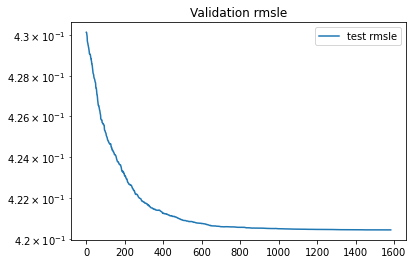

In [91]:
evals_result = xgb_gpu.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmse'][100:], label='test rmsle')
plt.title('Validation rmsle')
plt.legend()
plt.show()

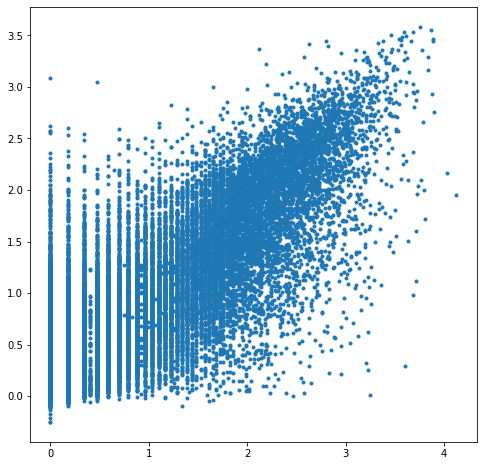

28.81351091945677


In [92]:
y_pred = xgb_gpu.predict(X_test)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_test, y_pred, ".")
# plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_test)-1, np.exp(y_pred)-1)) # previous best: 27.9057

# Bayesian Optimization

In [167]:
from sklearn.model_selection import train_test_split

X = data_train.drop(columns=["Id","Ground_truth", "number_sta", "baseline_obs"])
y = np.log(1 + data_train["Ground_truth"])
X_cv, X_val, y_cv, y_val = train_test_split(X, y, test_size=.2)

In [177]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import CheckpointSaver
from xgboost import XGBRegressor

def MAPE(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true+1)))

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return 100 - MAPE(np.exp(y) - 1, np.exp(y_pred) - 1)

parameter_space = dict(
    n_estimators = Integer(200, 1500, prior="uniform"),
    max_depth = Integer(3, 10, prior="uniform"),
    learning_rate = Real(0.01, 0.3, prior="uniform"),
    gamma = Real(1e-6, 1e+1, prior="log-uniform"),
    min_child_weight = Real(1e-6, 1e+1, prior="log-uniform"),
    max_delta_step = Real(1e-2, 1e+2, prior="log-uniform"),
    colsample_bylevel  = Real(0.2, 1, prior="uniform"),
    colsample_bynode = Real(0.2, 1, prior="uniform")
    # colsample_bytree = Real(0.5, 1, prior="uniform")
    # reg_alpha = Real(1e-6, 1e+1, prior="log-uniform"),
    # reg_lambda = Real(1e-6, 1e+1, prior="log-uniform")
)

xgb_gpu = XGBRegressor(
    objective = "reg:squarederror",
    # eval_metric = "rmse",
    tree_method = 'gpu_hist', 
    gpu_id = 0,
)

xgb_cpu = XGBRegressor(
    objective="reg:squarederror"
)

checkpoint_saver = CheckpointSaver("opt_checkpoints/opt_checkpoint_2.pkl", compress=9)

opt = BayesSearchCV(
    xgb_cpu,
    parameter_space,
    scoring=mape_scorer,
    fit_params=dict(eval_set=[(X_val, y_val)], early_stopping_rounds=10),
    n_iter=10,
    cv=3,
    verbose=5
)

opt.fit(X_cv, y_cv, callback=checkpoint_saver)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bylevel=0.7020994222267751, colsample_bynode=0.6142907855851673, gamma=1.817287815685178e-05, learning_rate=0.018823230438962033, max_delta_step=11.697578326932131, max_depth=6, min_child_weight=0.0027614221821077546, n_estimators=525;, score=68.753 total time=  53.6s
[CV 2/3] END colsample_bylevel=0.7020994222267751, colsample_bynode=0.6142907855851673, gamma=1.817287815685178e-05, learning_rate=0.018823230438962033, max_delta_step=11.697578326932131, max_depth=6, min_child_weight=0.0027614221821077546, n_estimators=525;, score=69.314 total time=  53.4s
[CV 3/3] END colsample_bylevel=0.7020994222267751, colsample_bynode=0.6142907855851673, gamma=1.817287815685178e-05, learning_rate=0.018823230438962033, max_delta_step=11.697578326932131, max_depth=6, min_child_weight=0.0027614221821077546, n_estimators=525;, score=69.011 total time=  55.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_delta_step': Real(low=0.01, high=100.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(lo

In [ ]:
# colsample_bylevel=0.9123335746345143, 
# colsample_bynode=0.7949060658350946, 
# colsample_bytree=1.0, 
# gamma=0.002942423609287807, 
# learning_rate=0.09749077636023099, 
# max_delta_step=0.0970329358188392, 
# max_depth=14, 
# min_child_weight=10.0, 
# n_estimators=2671;, 
# score=71.041 
# total time= 2.9min

# colsample_bylevel=1.0, 
# colsample_bynode=0.5, 
# colsample_bytree=1.0, 
# gamma=0.000392237407822539, 
# learning_rate=0.04640973110054612, 
# max_delta_step=10.0, 
# max_depth=14, 
# min_child_weight=10.0, 
# n_estimators=2107;, 
# score=71.591 
# total time= 5.3min

# colsample_bylevel=0.9361643554194089, colsample_bynode=0.5, colsample_bytree=1.0, gamma=1e-06, learning_rate=0.08677181776615807, max_delta_step=0.08950566759766272, max_depth=14, min_child_weight=10.0, n_estimators=3198;, score=71.512 total time= 7.6min

In [18]:
from skopt import load

res = load("opt_checkpoints/opt_checkpoint_2.pkl")

In [22]:
dir(res)
res.space

Space([Real(low=0.2, high=1, prior='uniform', transform='normalize'),
       Real(low=0.2, high=1, prior='uniform', transform='normalize'),
       Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
       Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
       Real(low=0.01, high=100.0, prior='log-uniform', transform='normalize'),
       Integer(low=3, high=10, prior='uniform', transform='normalize'),
       Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
       Integer(low=200, high=1500, prior='uniform', transform='normalize')])

In [179]:
opt.best_score_

71.98786833433823

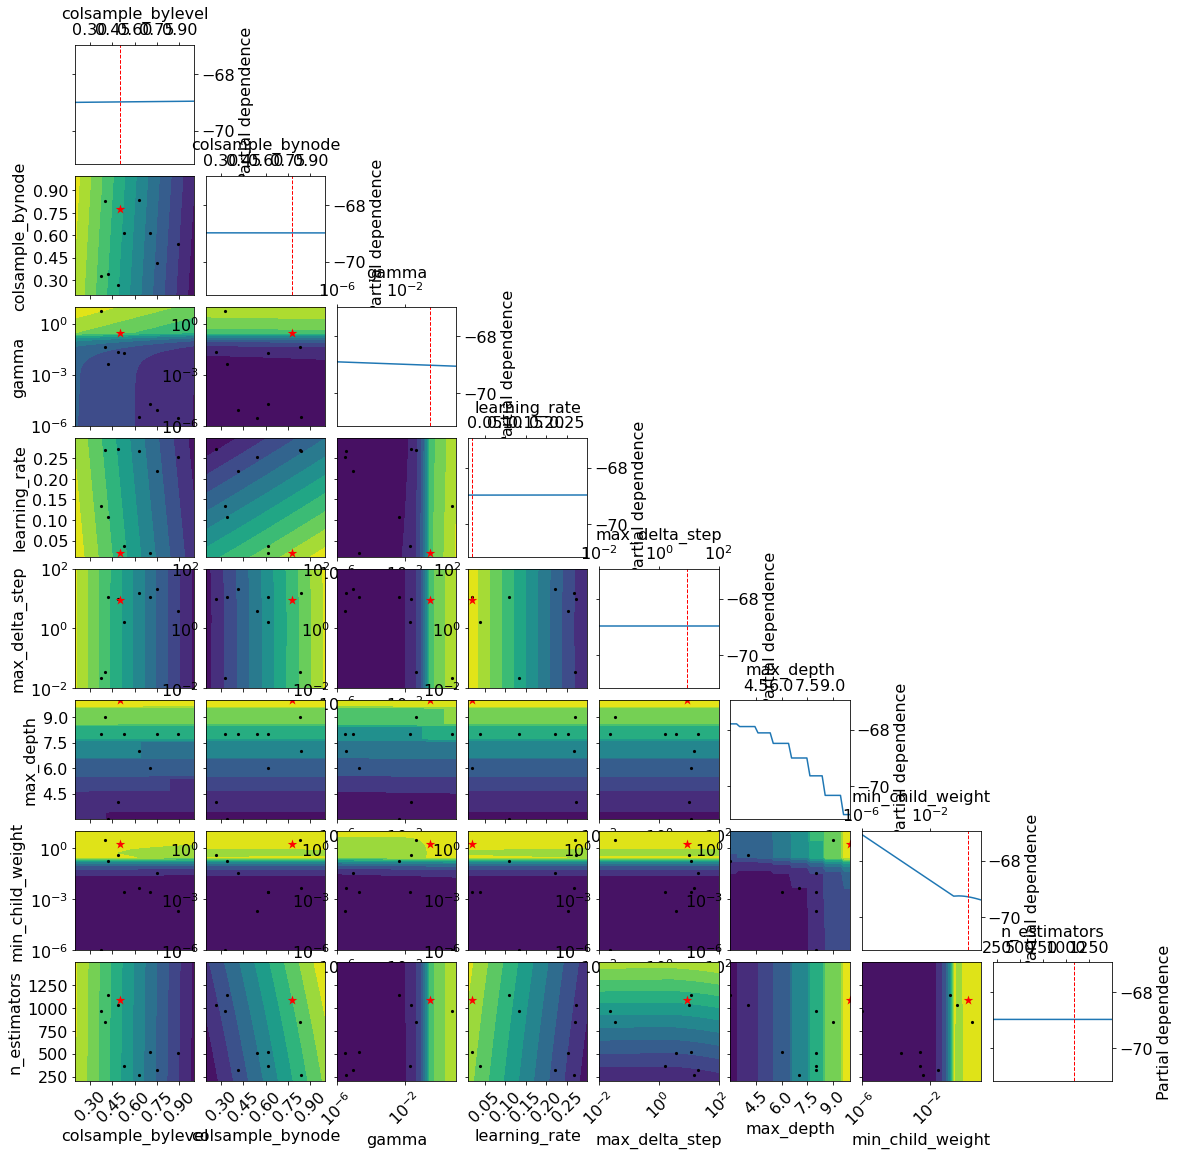

In [183]:
import skopt.plots

skopt.plots.plot_objective(
    res,
    # plot_dims=["n_estimators", "max_depth", "learning_rate", "gamma"]
    # bins=10
)
# plt.tight_layout()
plt.show()

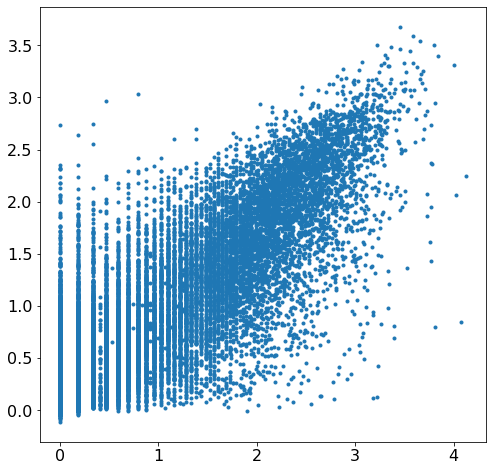

27.245362091107804


In [184]:
y_pred = opt.best_estimator_.predict(X_val)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_val, y_pred, ".")
# plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_val)-1, np.exp(y_pred)-1)) # previous best: 27.9057

In [ ]:
["baseline_pred", "lat", ]

In [17]:
opt.best_estimator_.get_booster().get_score(importance_type="gain")

NameError: name 'opt' is not defined

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

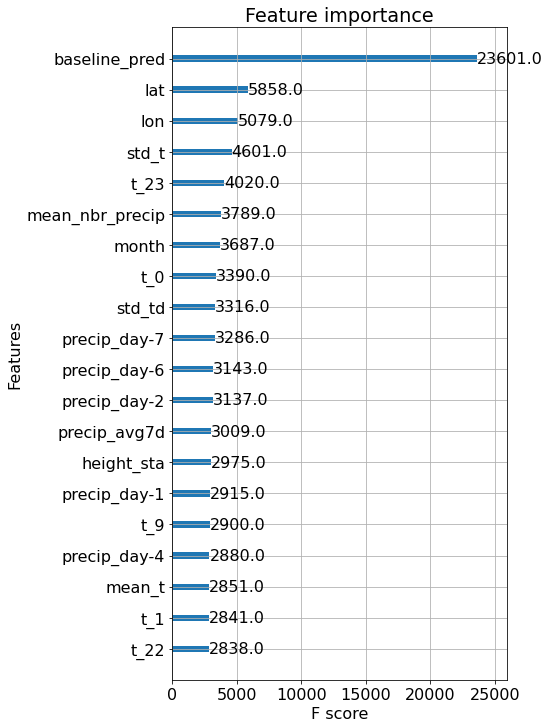

In [185]:
from xgboost import plot_importance

plt.figure(figsize=(6, 12))
plot_importance(opt.best_estimator_, max_num_features=20, ax=plt.gca())


# Final Model

In [13]:
from xgboost import XGBRegressor

# final_model = XGBRegressor(
#     objective = "reg:squarederror",
#     tree_method = 'gpu_hist', 
#     n_estimators = 200,
#     max_depth = 9,
#     learning_rate = 0.1,
#     gpu_id = 0,
#     verbosity=1
# )

# final_model = XGBRegressor(objective = "reg:squarederror", colsample_bylevel=0.5023667335183475, colsample_bynode=0.7786569530445597, gamma=0.29483532003269713, learning_rate=0.019200857028411795, max_delta_step=8.873241615295381, max_depth=10, min_child_weight=1.7307467212068013, n_estimators=1087) #opt.best_estimator_
final_model = XGBRegressor(objective = "reg:squarederror", learning_rate=0.1, max_depth=5, n_estimators=500)

In [14]:
final_model.fit(X_cv, y_cv, eval_set=[(X_cv, y_cv), (X_val, y_val)], early_stopping_rounds=10)
# final_model.fit(X, y, eval_set=[(X, y)], early_stopping_rounds=10)

[0]	validation_0-rmse:0.75987	validation_1-rmse:0.76364
[1]	validation_0-rmse:0.68814	validation_1-rmse:0.69128
[2]	validation_0-rmse:0.62404	validation_1-rmse:0.62649
[3]	validation_0-rmse:0.56666	validation_1-rmse:0.56853
[4]	validation_0-rmse:0.51549	validation_1-rmse:0.51687
[5]	validation_0-rmse:0.46982	validation_1-rmse:0.47075
[6]	validation_0-rmse:0.42929	validation_1-rmse:0.42982
[7]	validation_0-rmse:0.39332	validation_1-rmse:0.39351
[8]	validation_0-rmse:0.36146	validation_1-rmse:0.36137
[9]	validation_0-rmse:0.33340	validation_1-rmse:0.33310
[10]	validation_0-rmse:0.30853	validation_1-rmse:0.30800
[11]	validation_0-rmse:0.28663	validation_1-rmse:0.28619
[12]	validation_0-rmse:0.26760	validation_1-rmse:0.26711
[13]	validation_0-rmse:0.25111	validation_1-rmse:0.25079
[14]	validation_0-rmse:0.23669	validation_1-rmse:0.23653
[15]	validation_0-rmse:0.22408	validation_1-rmse:0.22433
[16]	validation_0-rmse:0.21341	validation_1-rmse:0.21403
[17]	validation_0-rmse:0.20414	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
X[["precip_shift", "baseline_pred"]]

,precip_shift,baseline_pred
0,1.481605,5.545129
226,2.541602,7.372426
449,0.470004,2.889161
671,0.336472,6.140569
892,1.386294,3.744201
...,...,...
161198,1.435085,10.618165
161424,0.000000,0.000239
161649,1.686399,5.269440
161878,1.856298,12.161292


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

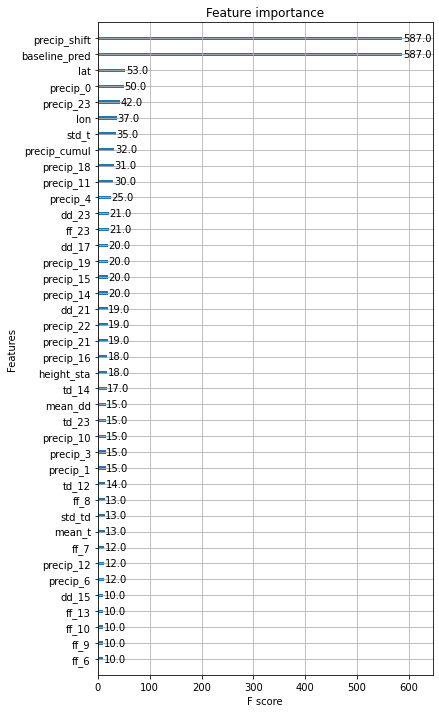

In [15]:
from xgboost import plot_importance

plt.figure(figsize=(6, 12))
plot_importance(final_model, max_num_features=40, ax=plt.gca())
# final_model.get_booster().get_score(importance_type="gain")

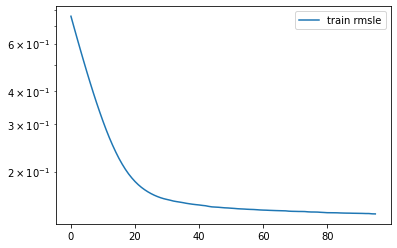

In [17]:
evals_result = final_model.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmse'], label='train rmsle')
# plt.semilogy(evals_result['validation_1']['rmse'], label='val rmsle')
# plt.title('Validation rmsle')
plt.legend()
plt.show()

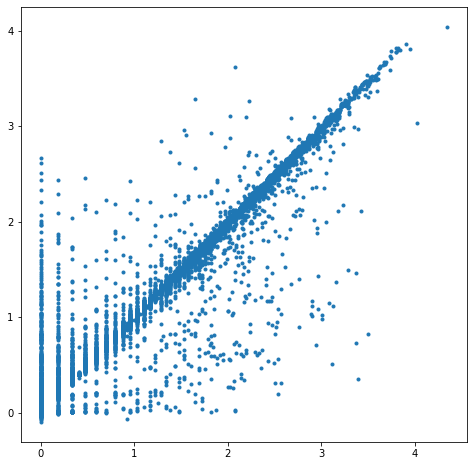

NameError: name 'MAPE' is not defined

In [18]:
y_pred = final_model.predict(X_val)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_val, y_pred, ".")
# plt.loglog(y+1, y_pred+1, ".")
plt.show()

# print(MAPE(y, y_pred)) # previous best: 28.0478
# print(MAPE(np.exp(y)-1, np.exp(y_pred)-1)) # previous best: 27.9057
print(MAPE(np.exp(y_val)-1, np.exp(y_pred)-1)) # previous best: 27.9057

# Test Data

In [197]:
X_eval = data_test[X.columns]#.drop(columns=["Id", "number_sta", "baseline"])

In [198]:
model_prediction = final_model.predict(X_eval)

In [199]:
submission_df = pd.DataFrame(dict(
    Id = data_test["Id"],
    Prediction = np.exp(model_prediction)
))

In [200]:
submission_df.to_csv("Submissions/submission_5.csv", index=False)